<a href="https://colab.research.google.com/github/victor3r/travelling-salesman/blob/main/travelling_salesman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introdução 

Os algoritmos genéticos (AGs) são um dos vários métodos que se utilizam para a resolução de problemas complexos. Este método tem por base um processo iterativo sobre uma determinada população fixa, denominados por indivíduos, que representam as várias soluções do problema. Esta técnica advém do processo de evolução dos seres vivos demonstrada por Darwin.

Da mesma forma que os sistemas biológicos, ao longo da sua evolução, tiveram que se «moldar» às alterações ambientais para a sua sobrevivência, os AGs acumulam a informação sobre o ambiente com o intuito de se adptarem ao novo meio. Tal informação funciona como um sistema de triagem para a obtenção de novas soluções exequíveis.

## O Problema

<p align="justify">O Problema do Caixeiro Viajante (PCV) é um problema que tenta determinar a menor rota para percorrer uma série de cidades (visitando uma única vez cada uma delas), retornando à cidade de origem. Ele é um problema de otimização NP-difícil inspirado na necessidade dos vendedores em realizar entregas em diversos locais (as cidades) percorrendo o menor caminho possível, reduzindo o tempo necessário para a viagem e os possíveis custos com transporte e combustível.</p>

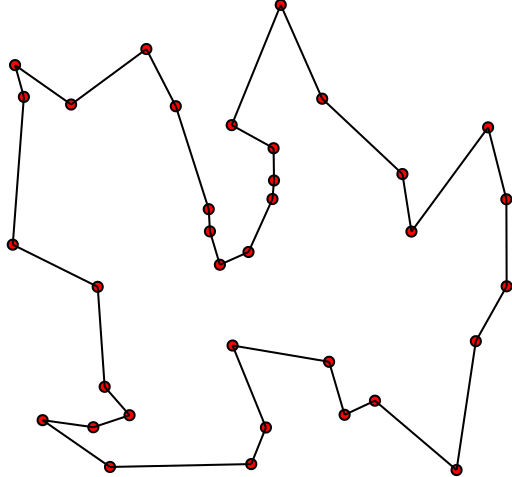

## Operadores genéticos

Algumas definições no contexto do PCV:

* **Gene:** uma cidade (representada como um identificador)
* **Indivíduo:** uma possível rota
* **População:** uma coleção de possíveis rotas
* **Pais:** duas rotas que combinadas criam uma nova
* **Crossover:** processo para criar novas rotas a partir de outras
* **Fitness:** uma função que diz quão boa uma rota é
* **Mutação:** uma maneira de introduzir variação na população através da troca aleatória de 2 cidades em uma rota
* **Elitismo:** uma maneira de levar os melhores indivíduos para a próxima geração

O AG irá funcionar da seguinte forma:

1. Criação da população
2. Determinação do fitness
3. Seleção e crossover
4. Mutação
5. Repetição

# Implementação

Primeiro é feito a importação de algumas bibliotecas que serão utilizadas

In [ ]:
import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt

## Criando duas classes: City e Fitness

É feito a criação de uma classe `City` para permitir manipular as cidades. Ela é composta por um `id`, que representa a posição no arquivo de distâncias. Depois é adicionado a propriedade `distance`, que é uma lista com todas as distâncias daquela cidade (coluna no arquivo de distâncias). Também é adicionado um método `__repr__` para ter uma melhor representação da cidade no `print`.

In [ ]:
class City:
  def __init__(self, id):
    self.id = id
    self.distances = pd.read_csv('distancias.txt', sep='   ', header=None, engine='python')[self.id].values.tolist()

  def distance(self, city):
    return self.distances[city.id]

  def __repr__(self):
    return str(self.id)

Também foi criada a classe `Fitness`. Nesse problema o fitness foi tratado como o inverso da distância, pois como o objetivo é minimizar a distância do caminho percorrido, um fitness maior é melhor. Na linha 10 é feito a verificação para começar e terminar na mesma cidade.

In [ ]:
class Fitness:
  def __init__(self, route):
    self.route = route

  def route_distance(self):
    path_distance = 0
    for i in range(len(self.route)):
      from_city = self.route[i]
      to_city = None
      if i + 1 < len(self.route):
        to_city = self.route[i + 1]
      else:
        to_city = self.route[0]
      path_distance += from_city.distance(to_city)
    return path_distance

  def route_fitness(self):
    return 1 / self.route_distance()

## Criando a população

Para criar um indivíduo foi selecionada aleatoriamente a ordem que cada cidade será visitada.

In [ ]:
def create_route(city_list):
  route = random.sample(city_list, len(city_list))
  return route

Também foi criada uma função de validação que verifica se existem cidades duplicadas na mesma rota.

In [ ]:
def validate(route, city_list):
  route_ids = [city.id for city in route]
  contains_duplicates = any(route_ids.count(id) > 1 for id in route_ids)
  
  if contains_duplicates:
    route = create_route(city_list)

  return route

Para criar uma população foi criada uma função que é simplesmente um loop para executar a função `create_route` até ter todas as rotas para a população.

In [ ]:
def initial_population(pop_size, city_list):
  population = []

  for _ in range(pop_size):
    population.append(create_route(city_list))
  return population

## Determinando o fitness

Foi usada a classe `Fitness` para ranquear cada indivíduo na população. A saída será uma lista ordenada de tuplas com cada indivíduo associado ao seu fitness.

In [ ]:
def rank_routes(population):
  fitness_results = [(route, Fitness(route).route_fitness()) for route in population]
  return sorted(fitness_results, key=operator.itemgetter(1), reverse=True)

Também foi criada uma função para calcular a distância média dos indivíduos de uma população.

In [ ]:
def avg_distance(population):
  cumsum = 0
  for i in range(len(population)):
    cumsum += 1 / Fitness(population[i]).route_fitness()
  return cumsum / len(population)

## Seleção e Crossover

Há algumas opções para selecionar os pais que serão usados para criar a próxima geração. As mais comuns são o **método da roleta** ou a **seleção por torneio**.

* **Método da roleta**: Cada indivíduo da população é representado na roleta
proporcionalmente ao seu valor de aptidão. Assim, para indivíduos com alta aptidão é dada uma porção maior da roleta, enquanto aos indivíduos de aptidão mais baixa, é dada uma porção relativamente menor.

* **Seleção por torneio** (a versão implementada abaixo): Um certo número de indivíduos é aleatoriamente selecionado da população e aquele com maior fitness é escolhido como o primeiro pai. O processo é repetido para a escolha do segundo.

Outra característica utilizada foi o **elitismo**. Com o elitismo, os melhores indivíduos de cada geração são automaticamente levados para a próxima geração, garantindo que os melhores sobrevivam.

Primeiro é feita a ordenação da população utilizando a função `rank_routes`, fazendo com que os indivíduos de melhor fitness fiquem nas primeiras posições. Com isso o loop é iniciado do final da população, fazendo com que os melhores não se alterem.

Depois é selecionada uma porção de indivíduos, que corresponde a 10% do tamanho da população, ordenando-os depois pelo fitness para os 2 melhores indivíduos serem selecionados como pais.

Com os pais selecionados é sorteado um ponto de corte aleatório para realizar o crossover entre os pais. Depois disso o indivíduo é validado utilizando a função `validate`.

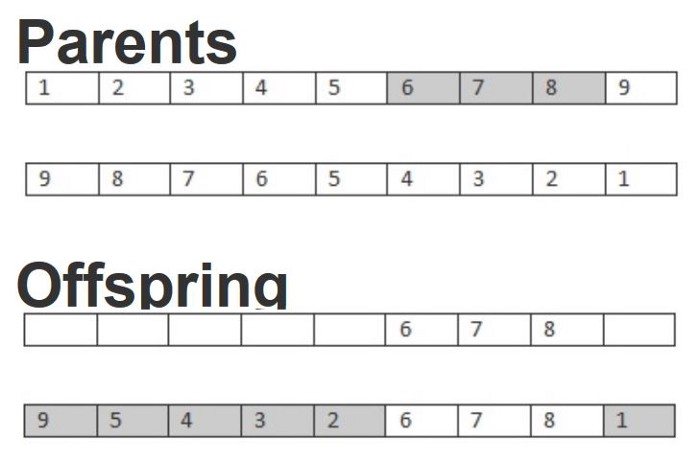

In [ ]:
def selection_and_crossover(population, elite_size, crossover_rate, city_list):
  population = [individual[0] for individual in rank_routes(population)]
  for i in range(len(population) - 1, elite_size - 1, -1):
    if(random.random() < crossover_rate):
      sample = random.sample(population, int(len(population) * 0.1))
      sample_ranked = [individual[0] for individual in rank_routes(sample)]
      parent1 = sample_ranked[0]
      parent2 = sample_ranked[1]
      point = random.randint(1, len(population[i]) - 1)
      population[i][:point] = parent1[:point]
      population[i][point:] = parent2[point:]
      population[i] = validate(population[i], city_list)
  return population

## Mutação

Mutação tem uma importante função em um AG, pois ajuda a evitar estagnações em um mínimo local através da introdução de novas rotas que irão permitir a exploração de novos espaços de busca.

Nesse contexto não é possível descartar cidades, então foi usada a técnica de **swap mutation**. O que significa que é especificado uma baixa probabilidade para duas cidades trocarem de lugar em uma rota. Isso é feito para um indivíduo na função `mutate`.

In [ ]:
def mutate(individual, mutation_rate):
  for swapped in range(len(individual)):
    if(random.random() < mutation_rate):
      swap_with = int(random.random() * len(individual))

      city1 = individual[swapped]
      city2 = individual[swap_with]

      individual[swapped] = city2
      individual[swap_with] = city1
  return individual

Com isso é possível agora usar a função `mutate` para percorrer a nova população.

In [ ]:
def mutate_population(population, mutation_rate, elite_size):
  for ind in range(len(population) - 1, elite_size - 1, -1):
    population[ind] = mutate(population[ind], mutation_rate)
  return population

## Repetição

Agora é criada uma função para produzir uma nova geração. É possível determinar os possíveis pais executando a função `selection_and_crossover`, que permite criar a nova geração, e depois é aplicado mutação usando a função `mutate_population`.

In [ ]:
def next_generation(current_gen, elite_size, mutation_rate, crossover_rate, city_list):
  children = selection_and_crossover(current_gen, elite_size, crossover_rate, city_list)
  next_generation = mutate_population(children, mutation_rate, elite_size)
  return next_generation

## Evolução

É criada a população inicial e então aplicado um loop para quantas gerações forem necessárias. Também é mostrado a distância inicial na linha 3 (distância é o inverso do fitness), a distância final na linha 8 e a melhor rota na linha 9.

In [ ]:
def genetic_algorithm(city_list, pop_size, elite_size, mutation_rate, crossover_rate, generations):
  pop = initial_population(pop_size, city_list)
  print('Distância inicial: {}'.format(1 / rank_routes(pop)[0][1]))

  for i in range(generations):
    pop = next_generation(pop, elite_size, mutation_rate, crossover_rate, city_list)

  print('Distância final: {}'.format(1 / rank_routes(pop)[0][1]))
  best_route = rank_routes(pop)[0][0]
  return best_route

# Rodando o algoritmo genético

Primeiro é criada a lista de cidades. Para esse caso foi criada uma lista com todas as 16 cidades do arquivo de distâncias.

In [ ]:
city_list = []
distances = pd.read_csv('distancias.txt', sep='   ', header=None, engine='python')
number_of_cities = len(distances)

for i in range(number_of_cities):
  city_list.append(City(i))

Então o algoritmo genético pode ser rodado em uma única linha de código. Nesse ponto é necessário ajustar os parâmetros para obter os melhores resultados. Nesse exemplo foi usado uma população de 100 indivíduos em cada geração, mantendo 20 indivíduos na elite, usando 10% de taxa de mutação e 90% de taxa de crossover, e rodando o algoritmo para 50 gerações.

In [ ]:
genetic_algorithm(city_list, pop_size=100, elite_size=20, mutation_rate=0.1, crossover_rate=0.9, generations=50)

Distância inicial: 28.06
Distância final: 15.499999999999996


[4, 12, 0, 6, 11, 15, 1, 8, 9, 2, 5, 7, 13, 3, 10, 14]

## Plotando a evolução

Para visualizar a melhora do fitness ao longo das gerações é feita uma simples alteração na função `genetic_algorithm`, armazenando a menor distância e a distância média de cada geração nas listas `best_distance_progress` e `avg_distance_progress` respectivamente, e também é feito o mesmo para o fitness, que é o inverso da distância. Então os resultados são plotados.

In [ ]:
def genetic_algorithm_plot(city_list, pop_size, elite_size, mutation_rate, crossover_rate, generations):
  pop = initial_population(pop_size, city_list)
  best_distance_progress = []
  best_fitness_progress = []
  avg_distance_progress = []
  avg_fitness_progress = []

  best_distance_progress.append(1 / rank_routes(pop)[0][1])
  avg_distance_progress.append(avg_distance(pop))
  best_fitness_progress.append(rank_routes(pop)[0][1])
  avg_fitness_progress.append(1 / avg_distance(pop))

  for i in range(generations):
    pop = next_generation(pop, elite_size, mutation_rate, crossover_rate, city_list)
    best_distance_progress.append(1 / rank_routes(pop)[0][1])
    avg_distance_progress.append(avg_distance(pop))
    best_fitness_progress.append(rank_routes(pop)[0][1])
    avg_fitness_progress.append(1 / avg_distance(pop))


  plt.plot(avg_distance_progress)
  plt.plot(best_distance_progress)
  plt.legend(['Média','Melhor'], bbox_to_anchor=(1.05, 1), loc='upper left')
  plt.ylabel('Distância')
  plt.xlabel('Geração')
  plt.show()

  plt.plot(avg_fitness_progress)
  plt.plot(best_fitness_progress)
  plt.legend(['Média','Melhor'], bbox_to_anchor=(1.05, 1), loc='upper left')
  plt.ylabel('Fitness')
  plt.xlabel('Geração')
  plt.show()

Rodando o AG com os mesmos parâmetros anteriores, mas agora usando a nova função `genetic_algorithm_plot`.

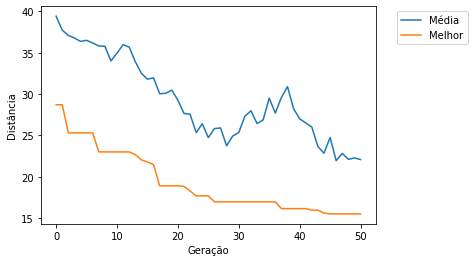

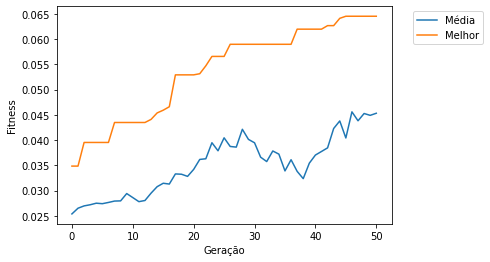

In [ ]:
genetic_algorithm_plot(city_list, pop_size=100, elite_size=20, mutation_rate=0.1, crossover_rate=0.9, generations=50)

# Conclusão

Portanto, um algoritmo genético é uma técnica de busca utilizada na ciência da computação para achar soluções aproximadas em problemas de otimização e busca,usando técnicas inspiradas pela biologia evolutiva.

O problema proposto para ser solucionado foi um problema de busca para uma menor rota entre cidades.

A solução encontrada pode ser considerada boa uma vez que a diminuição da distância total do caminho ao longo das gerações é perceptível.

Entretanto é possível achar soluções diferentes alterando o método de implementação das funções `selection_and_crossover` e `mutate`, além de ser possível também ajustar os parâmetros da função.